In [1]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/Excessive-invariance')
sys.path.append(str(base))

Mounted at /content/drive


In [2]:
import os
os.chdir("/")
os.chdir("content/drive/My Drive/Excessive-invariance")
os.listdir()

['Test.ipynb',
 'data',
 '__pycache__',
 'img.jpg',
 'baraholka.py',
 'results',
 'pretrained_models',
 'utils.py',
 'autoencoder.ipynb',
 'models.py',
 'Untitled0.ipynb']

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchsummary
from torch.autograd import Variable, Function
from copy import deepcopy
from itertools import chain
import math
import pandas as pd
from PIL import Image

from utils import *
from models import *

In [4]:
num_epochs = 5
batch_size = 64
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Some preparation

In [5]:
transform = transforms.ToTensor()

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform);
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True);

val_data = datasets.MNIST('./data', train=False, download=True, transform=transform);
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False);

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

In [6]:
# download pretrained autoencoder
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('pretrained_models/autoencoder.pth'))
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in

In [7]:
#download pretrained classifier
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('pretrained_models/semantic_classifier.pth'))
classifier.eval()

Classifier(
  (classifier): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

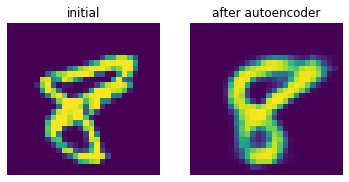

In [8]:
#check if autoencoder is ok
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_data))
img, _ = val_data[index]
plt.title('initial')
plt.axis('off')
plt.imshow(torch.reshape(img, (28,28)));

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = autoencoder(img.view(img.shape[0], -1))
img_encoded = torch.reshape(img_encoded, (28, 28))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach());

In [9]:
def adversarial_example(model, input, target, num_iter, alpha, collect_history=False):
  model.eval()
  history = []
  history_residual = []
  with torch.set_grad_enabled(True):
    
    input = torch.reshape(input, (1, 28*28)).to(device)
    target = torch.reshape(target, (1, 28*28)).to(device)
    img = deepcopy(input)
    output_targ = model(target)[:, :10]
    best_loss = 10000.
    best_img = deepcopy(img)
    img = Variable(img, requires_grad=True)
    for i in range(num_iter):
      
      output = model(img)
      output = output[:, :10]
      loss = torch.norm(output - output_targ, p=2)
      loss.backward(retain_graph=True)

      if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = deepcopy(img)
      
      if collect_history:
          x, residual, _,_ = np.linalg.lstsq(A.T, output.squeeze().detach().numpy()-x0)
          history.append(x)
          history_residual.append(residual)
      
      #step
      img.data -= alpha * torch.sign(img.grad.data)
    #  img = img.mul(torch.Tensor(std)).add(torch.Tensor(-mean))
    #  img = torch.clamp(img, 0, 1)
    #  img = transforms.Normalize(mean, std)(img)
            
  if collect_history:
      return history, history_residual
  return best_img, best_loss

In [33]:
def take_ranom_digit(label):
    idx = [x for x in train_data if x[-1] == label]
    index = np.random.randint(len(idx))
    img, _ = idx[index]
    return img

In [ ]:
#indices of all ones
idx = [x for x in train_data if x[-1] == 1]


### Check all space of ones

In [50]:
# u, v - vectors to define plane
index1 = np.random.randint(len(idx))
img1, label1 = idx[index1]
semantic1 = autoencoder.encoder(torch.reshape(img1, (1, 28*28)))[:, :10]#.squeeze()

index2 = np.random.randint(len(idx))
img2, label2 = idx[index2]
semantic2 = autoencoder.encoder(torch.reshape(img2, (1, 28*28)))[:, :10]#.squeeze()

index3 = np.random.randint(len(idx))
img3, label3 = idx[index3]
semantic3 = autoencoder.encoder(torch.reshape(img3, (1, 28*28)))[:, :10]#.squeeze()

u = semantic1 - semantic2
v = semantic2 - semantic3

A = torch.cat([u,v]).detach().numpy()


In [51]:
x = take_ranom_digit(1)
x_semantic = autoencoder.encoder(torch.reshape(x, (1, 28*28)))[:, :10].squeeze().detach().numpy()
np.linalg.lstsq(A.T, x_semantic-semantic1[:, :10].squeeze().detach().numpy())[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


array([-1.3166403, -0.862797 ], dtype=float32)

In [52]:
adv, loss = adversarial_example(autoencoder.encoder, img1, img2, num_iter=20, alpha=1./255)

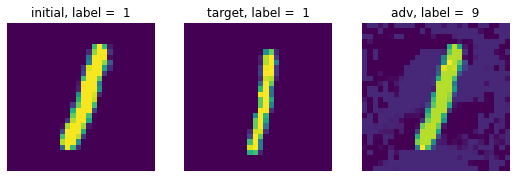

In [53]:
fig = plt.figure(figsize=(9,3))
fig.add_subplot(1, 3, 1)
plt.title('initial, label =  {}'.format(classifier.predict_by_image(img1, autoencoder)))
plt.axis('off')
plt.imshow(torch.reshape(img1, (28,28)));

fig.add_subplot(1, 3, 2)
plt.title('target, label =  {}'.format(classifier.predict_by_image(img2, autoencoder)))
plt.axis('off')
plt.imshow(torch.reshape(img2, (28,28)));

fig.add_subplot(1, 3, 3)
plt.title('adv, label =  {}'.format(classifier.predict_by_image(adv, autoencoder)))
plt.axis('off')
plt.imshow(torch.reshape(adv, (28,28)).detach().numpy());

In [54]:
adv_semantic = autoencoder.encoder(torch.reshape(adv, (1, 28*28)))[:,:10].squeeze()
np.linalg.lstsq(A.T, adv_semantic.detach().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


(array([0.6578903 , 0.39130166], dtype=float32),
 array([1.2258012], dtype=float32),
 2,
 array([2.5079622, 1.2661893], dtype=float32))

In [55]:
idx = [x for x in train_data if x[-1] == 1]
results = []
residuals = []
x0 = semantic1[:, :10].squeeze().detach().numpy()
for img, _ in idx:
    semantic = autoencoder.encoder(torch.reshape(img, (1, 28*28)))[:, :10].squeeze().detach().numpy()
    x, residual, _, _ = np.linalg.lstsq(A.T, semantic-x0)
    results.append(x)
    residuals.append(residual)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


In [56]:
result_adv, residual_adv = adversarial_example(autoencoder.encoder, img1, img2, num_iter=100, alpha=1./255, collect_history=True)
result_adv = np.array(result_adv)
residual_adv = np.array(residual_adv).T[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


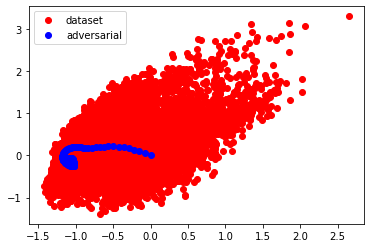

In [57]:
results = np.array(results)
plt.plot(results[:,0], results[:,1], 'ro', label='dataset')
plt.plot(result_adv[:,0], result_adv[:,1], 'bo', label='adversarial')
plt.legend();

In [58]:
residuals = np.array(residuals)

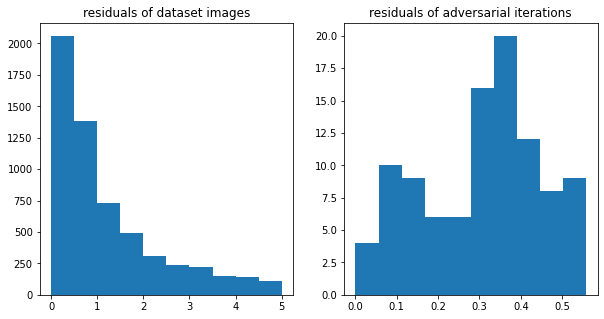

In [59]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1, 2, 1)
plt.hist(residuals.T[0], range=(0,5));
plt.title('residuals of dataset images');
fig.add_subplot(1, 2, 2)
plt.hist(residual_adv);
plt.title('residuals of adversarial iterations');


###Try another digit

In [65]:

# u, v - vectors to define plane
idx = [x for x in train_data if x[-1] == 7]

index1 = np.random.randint(len(idx))
img1, label1 = idx[index1]
semantic1 = autoencoder.encoder(torch.reshape(img1, (1, 28*28)))[:, :10]#.squeeze()

index2 = np.random.randint(len(idx))
img2, label2 = idx[index2]
semantic2 = autoencoder.encoder(torch.reshape(img2, (1, 28*28)))[:, :10]#.squeeze()

index3 = np.random.randint(len(idx))
img3, label3 = idx[index3]
semantic3 = autoencoder.encoder(torch.reshape(img3, (1, 28*28)))[:, :10]#.squeeze()

u = semantic1 - semantic2
v = semantic2 - semantic3
x0 = semantic1.squeeze().detach().numpy()

A = torch.cat([u,v]).detach().numpy()

In [66]:
result_adv, residual_adv = adversarial_example(autoencoder.encoder, img1, img2, num_iter=100, alpha=1./255, collect_history=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [67]:
inp, residual_inp, _,_ = np.linalg.lstsq(A.T, semantic1.squeeze().detach().numpy()-x0)
targ, residual_targ, _,_ = np.linalg.lstsq(A.T, semantic2.squeeze().detach().numpy()-x0)
#residual_inp.item(), residual_targ.item()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


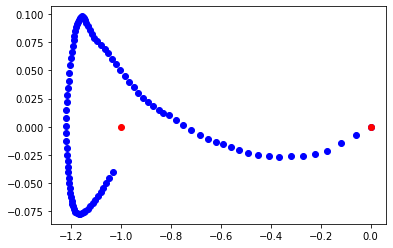

In [68]:
result_adv = np.array(result_adv)
plt.plot(result_adv[:,0], result_adv[:,1], 'bo')
plt.plot(inp[0],inp[1], 'ro')
plt.plot(targ[0],targ[1], 'ro')


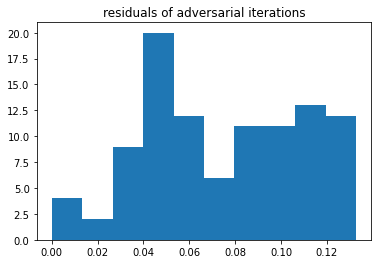

In [69]:
plt.hist(np.array(residual_adv).T[0]);
plt.title('residuals of adversarial iterations');

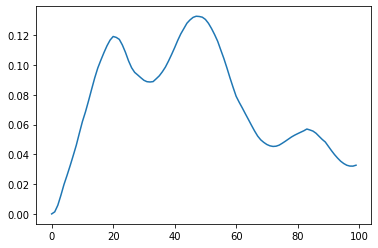

In [70]:
plt.plot(np.array(residual_adv).T[0])